In [1]:
import _init_paths
import os, sys, cv2, pickle, h5py, imutils
import os.path as osp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy.random as npr
import pandas as pd

from Config import Config
from datasets.Pascal import Pascal
from retriever.Rendering import Rendering
from datasets.ROIGenerator import ROIGenerator

from sklearn.metrics.pairwise import pairwise_distances

In [2]:
# setup & load configs
_C = Config(config_pn="../config/config_SSDH.ini")
cfg = _C.cfg

In [3]:
ds_name = "voc_2007"
dataset_DIR = osp.join(cfg.MAIN_DIR_ROOT, "data", ds_name)
dataset = Pascal(name=ds_name, path_dir=dataset_DIR, cfg=cfg)
dataset.load_sets()
print ('[INFO] dataset.name: {}'.format(dataset.name))
print ('[INFO] dataset.num_cls: {}'.format(dataset.num_cls))
print ('[INFO] dataset.train: {}'.format(dataset.sets["train"]["num_items"]))
print ('[INFO] dataset.trainval: {}'.format(dataset.sets["trainval"]["num_items"]))
print ('[INFO] dataset.test: {}'.format(dataset.sets["test"]["num_items"]))
print ('[INFO] dataset.val: {}'.format(dataset.sets["val"]["num_items"]))

[INFO] dataset.name: voc_2007
[INFO] dataset.num_cls: 21
[INFO] dataset.train: 2501
[INFO] dataset.trainval: 5011
[INFO] dataset.test: 4952
[INFO] dataset.val: 2510


In [4]:
train_images, _ = dataset.load_gt_rois(gt_set="trainval")
train_images = [image for image in train_images if not image.rois["gt"]['flipped']]
val_images, _ = dataset.load_gt_rois(gt_set="test")
print ('[INFO] train_images.num: {}'.format(len(train_images)))
print ('[INFO] val_images.num: {}'.format(len(val_images)))

[INFO] loading gt rois for voc_2007...
[INFO] images with gt loaded from /home/rfm/eclipse/python/region-dh/cache/voc_2007_gt_trainval_images.pkl
[INFO] loading gt rois for voc_2007...
[INFO] images with gt loaded from /home/rfm/eclipse/python/region-dh/cache/voc_2007_gt_test_images.pkl
[INFO] train_images.num: 5011
[INFO] val_images.num: 4952


In [5]:
train_dbs_DLBHC_48b = "../data/voc_2007/deep_dbs/voc_2007_trainval_DLBHC.bot-FT_emb_48.hdf5"
train_dbs_SSDH_48b = "../data/voc_2007/deep_dbs/voc_2007_trainval_SSDH_emb_48.hdf5"
train_dbs_RegionDH_48b = "../data/voc_2007/deep_dbs/voc_2007_trainval_Region-DH.bot-FT_iter_100221_emb_48.hdf5"

val_dbs_DLBHC_48b = "../data/voc_2007/deep_dbs/voc_2007_val_DLBHC.bot-FT_emb_48.hdf5"
val_dbs_SSDH_48b = "../data/voc_2007/deep_dbs/voc_2007_val_SSDH_emb_48.hdf5"
val_dbs_RegionDH_48b = "../data/voc_2007/deep_dbs/voc_2007_val_Region-DH.bot-FT_iter_100221_emb_48.hdf5"

In [6]:
train_dbs_DLBHC = h5py.File(train_dbs_DLBHC_48b, mode="r")
train_dbs_SSDH = h5py.File(train_dbs_SSDH_48b, mode="r")
train_dbs_RegionDH = h5py.File(train_dbs_RegionDH_48b, mode="r")

val_dbs_DLBHC = h5py.File(val_dbs_DLBHC_48b, mode="r")
val_dbs_SSDH = h5py.File(val_dbs_SSDH_48b, mode="r")
val_dbs_RegionDH = h5py.File(val_dbs_RegionDH_48b, mode="r")

In [7]:
train_hash_DLBHC = train_dbs_DLBHC["binarycode"]
train_hash_SSDH = train_dbs_SSDH["binarycode"]
train_hash_RegionDH = train_dbs_RegionDH["binarycode"]

val_hash_DLBHC = val_dbs_DLBHC["binarycode"]
val_hash_SSDH = val_dbs_SSDH["binarycode"]
val_hash_RegionDH = val_dbs_RegionDH["binarycode"]

In [8]:
print(len(train_hash_DLBHC))
print(len(train_hash_SSDH))
print(len(train_hash_RegionDH))
print(len(val_hash_DLBHC))
print(len(val_hash_SSDH))
print(len(val_hash_RegionDH))

4992
4992
5011
4928
4928
4952


In [10]:
train_images = train_images[:len(train_hash_DLBHC)]
val_images = val_images[:len(val_hash_DLBHC)]
print(len(train_images))
print(len(val_images))

4992
4928


In [11]:
def lp_to_names(lp, ds):
    id_to_cls = {v:k for (k,v) in ds.cls_to_id.items()}
    names = []
    for i, b in enumerate(lp):
        if b == 1:
            names.append(id_to_cls[i+1])
    
    return names

def find_similars(sel_id, qry_hashes, tgt_hashes, top_k=5):
    qry_hash = qry_hashes[sel_id]
    qry_hash = np.reshape(qry_hash, [1, -1])
    rlt_dists = pairwise_distances(qry_hash, tgt_hashes, 'hamming')[0]
    s_indexes = rlt_dists.argsort()

    qry_rlts = sorted([(rlt_dists[k], k) for k in s_indexes]) 
    qry_rlts = [(dist, k) for dist, k in qry_rlts]
    qry_rlts = qry_rlts[:top_k]
    
    return qry_rlts

def vis_query(image, item_dim=(50, 50)):
    im_RAW = cv2.imread(image.pathname)   
    im_RAW = cv2.cvtColor(im_RAW, cv2.COLOR_BGR2RGB)
    #im_RAW = imutils.resize(im_RAW, width=item_dim[0])
    #im_RAW = cv2.resize(im_RAW, item_dim)    
    plt.imshow(im_RAW)
    _ = plt.axis("off")
    
    return im_RAW

def vis_results(qry_rlts, qry_image, train_images, item_dim=(50, 50)):    
    rendering = Rendering(item_dim, len(qry_rlts), len(qry_rlts))
    
    for i, (dist, k) in enumerate(qry_rlts):
        tgt_image = train_images[k]        
        result = cv2.imread("{}".format(tgt_image.pathname))
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        
        cross = np.multiply(qry_image.rois["gt"]["labels"], tgt_image.rois["gt"]["labels"])
        is_rel = (np.sum(cross) > 0)
        
        rendering.addResult(result, text="#{}".format(i + 1), highlight=is_rel)
        
    return rendering

['sheep']


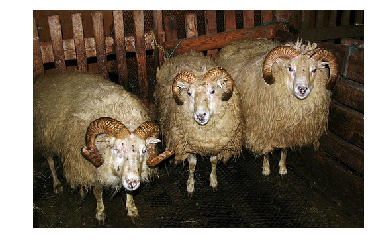

In [42]:
#sel_id = np.random.permutation(len(val_images))[0]
sel_id = 4066
image = val_images[sel_id]
im_lp = image.rois["gt"]["labels"]
print(lp_to_names(im_lp, dataset))
#print(sel_id)
#print(image.pathname)
im_RAW = cv2.imread(image.pathname)   
im_RAW = cv2.cvtColor(im_RAW, cv2.COLOR_BGR2RGB)
plt.imshow(im_RAW)
_ = plt.axis("off")

In [14]:
#sel_id = np.random.permutation(len(val_images))[0]
rlts_DLBHC = find_similars(sel_id, val_hash_DLBHC, train_hash_DLBHC, top_k=5)
rlts_SSDH = find_similars(sel_id, val_hash_SSDH, train_hash_SSDH, top_k=5)
rlts_RegionDH = find_similars(sel_id, val_hash_RegionDH, train_hash_RegionDH, top_k=5)

vis_DLBHC = vis_results(rlts_DLBHC, val_images[sel_id], train_images, item_dim=(100, 100))
vis_SSDH = vis_results(rlts_SSDH, val_images[sel_id], train_images, item_dim=(100, 100))
vis_RegionDH = vis_results(rlts_RegionDH, val_images[sel_id], train_images, item_dim=(100, 100))

In [43]:
im_top_left = cv2.resize(im_RAW, (100, 100))
im_top_right = np.ones((100, 400, 3), dtype="uint8")*255
im_top = np.hstack((im_top_left, im_top_right))

im_right = np.vstack((im_top, vis_DLBHC.view, vis_SSDH.view, vis_RegionDH.view))
im_left_1 = np.ones((100, 200, 3), dtype="uint8")*255
im_left_2 = np.ones((100, 200, 3), dtype="uint8")*255
im_left_3 = np.ones((100, 200, 3), dtype="uint8")*255
im_left_4 = np.ones((100, 200, 3), dtype="uint8")*255

cv2.putText(im_left_1, "Query", (5, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2)
cv2.putText(im_left_2, "DLBHC", (5, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2)
cv2.putText(im_left_3, "SSDH", (5, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2)
cv2.putText(im_left_4, "Region-DH", (5, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2)
im_left = np.vstack((im_left_1, im_left_2, im_left_3, im_left_4))

im_rendering = np.hstack((im_left, im_right))

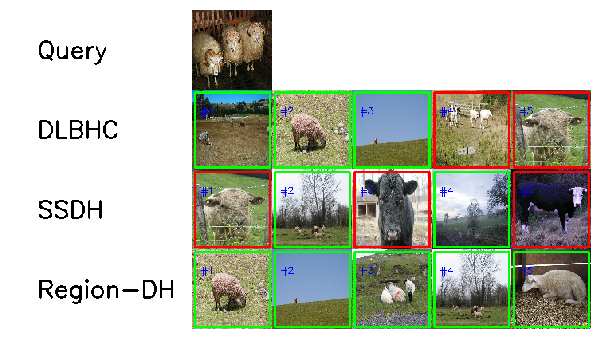

In [45]:
fig = plt.figure(figsize=(10, 20))
plt.imshow(im_rendering)
_ = plt.axis("off")